# Width extraction of the asparagus pieces 

In [267]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, io
from scipy.ndimage.morphology import binary_opening, binary_closing, binary_dilation
from scipy.ndimage import label, find_objects
import skimage as sk

In [271]:
# functions from Thomas' preprocessing
# I just copied these and altered them a little to fit my needs

def binarize_asparagus_img(img):
    
    def blue_delta(img):
        """
        returns the delta between blue and the avg other channels 
        """
        other = np.mean(img[:,:,0:2], axis=2)
        return img[:,:,2]-other
    
    img_bw = np.sum(img, axis=2)
    img_bw = img_bw/np.max(img_bw)*255
    white = img_bw > 90
    blue = blue_delta(img) > 25
    return np.logical_and(white, np.invert(blue))

def filter_mask_img(img):
    # I only use opening here because I want to change the size of the asparagus piece as little as possible
    # I only want to remove small white spots that are most likely due to reflections
    img = binary_opening(img, structure=np.ones((21,21)))
    return img

In [272]:
'''
simple length extraction - it doesn't take rotation into account
it is measured from the highest white pixel to the lowest in the binarized image
'''
def get_length(img):
    # use Thomas helper functions to get the boolean image
    img_mask = filter_mask_img(binarize_asparagus_img(img))
    # set labels to the different areas, which are in our case only two - background and asparagus
    img_labeled = sk.measure.label(img_mask)
    # regionprops extracts all kinds of features from the labeld image
    props = sk.measure.regionprops(img_labeled)
    # we only need the properties from the bounding box
    min_row, min_col, max_row, max_col = props[0].bbox
    # finally we can calculate the length by subtracting the min from the max pixel position
    length = max_row - min_row
    return length

In [303]:
'''
function to get the rows in which the image width shoudl be measured
slice the image into k even parts in which the widths should be measured
'''
def get_slices(img, k):
    slices = []
    # get the length of the asperagus piece
    length = get_length(img)
    # calculate the distance between each slice
    slice_dist = int(length/k)
    # the first slice shouldn't be at the very top of the piece but a little further down
    start = min_row + int(slice_dist/2)
    # save the row where the distance should be measured in the array slices
    for i in range(k):
        row = start + i*slice_dist
        slices.append(row)
    return slices

In [304]:
'''
Get start and end pixel of horizontal slices
input: img, k
output: start and end pixelof asparagus k different rows
'''
def get_horizontal_slices(img, k):
    img_mask = filter_mask_img(binarize_asparagus_img(img))
    slices = get_slices(img,k)
    horizontal_slices = np.zeros((k,2))
    for i in range(k):
        start = np.argwhere(img_mask[slices[i]]==True)[0]
        horizontal_slices[i][0] = start[0]
        end = np.argwhere(img_mask[slices[i]]==True)[-1]
        horizontal_slices[i][1] = end[0]
    
    return horizontal_slices

In [308]:
'''
Extract the width at k different rows
input: img and k
output: width at k different rows
'''
def get_width(img, k):
    slices = get_slices(img,k)
    img_mask = filter_mask_img(binarize_asparagus_img(img))
    width = np.zeros((k))
    for i in range(k):
        width[i] = np.sum(img_mask[slices[i]])
    return width
        

In [315]:
# load the image
img = io.imread('Images/0_2.jpg').astype(float)
# set the pixel values to the right range
img /= img.max()

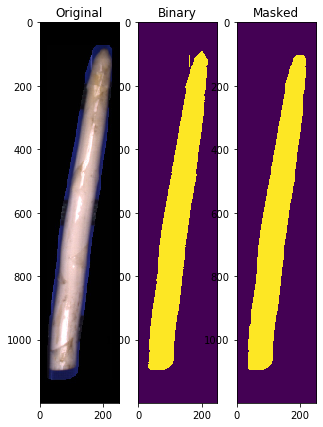

In [316]:
# binarize the image
img_binary = binarize_asparagus_img(img)

# mask it
img_mask = filter_mask_img(img_binary)

# show all three steps
fig, axs = plt.subplots(ncols=3, sharex=False, figsize=(5, 7))
axs[0].set_title('Original')
axs[0].imshow(img)

axs[1].set_title('Binary')
axs[1].imshow(img_binary)

axs[2].set_title('Masked')
axs[2].imshow(img_mask)

plt.show()

In [317]:
width = get_width(img, 5)
length = get_length(img)
horizontal_slices = get_horizontal_slices(img, 5)

print("Width: ", width)
print("Length: ", length)
print("Slices: ", horizontal_slices)

Width:  [64. 73. 81. 80. 79.]
Length:  994
Slices:  [[150. 213.]
 [119. 191.]
 [ 84. 164.]
 [ 61. 140.]
 [ 36. 114.]]
